In [1]:
from numpy import *
from pandas import *
from matplotlib.pyplot import *
from seaborn import *
from os import *
from sklearn import *
from category_encoders import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
bank = read_csv("bank.csv", delimiter = ";")
print(bank.shape)
print(path.getsize("bank.csv"))
bank.head()

(4521, 17)
461474


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
bank_full = read_csv("bank-full.csv", delimiter = ";")
print(bank_full.shape)
print(path.getsize("bank-full.csv"))
bank_full.head()

(45211, 17)
4610348


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


------

## Data Understanding

(Extracted from the bank-names.txt, section 7.)

Input variables:
   - bank client data:
       1. age (numeric)
       2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
       3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
       4. education (categorical: "unknown","secondary","primary","tertiary")
       5. default: has credit in default? (binary: "yes","no")
       6. balance: average yearly balance, in euros (numeric) 
       7. housing: has housing loan? (binary: "yes","no")
       8. loan: has personal loan? (binary: "yes","no")
   - related with the last contact of the current campaign:
       9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
       10. day: last contact day of the month (numeric)
       11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
       12. duration: last contact duration, in seconds (numeric)
   - other attributes:
       13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
       14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
       15. previous: number of contacts performed before this campaign and for this client (numeric)
       16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
   - Output variable (desired target):
       17. y - has the client subscribed a term deposit? (binary: "yes","no")


## Data Cleaning and Processing

1. Checking null and N/A values

In [4]:
print(bank_full.isnull().any())
print(bank_full.isna().any())

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool


No null or N/A values are presented

2. Checking outliers
    - First of all, select all columns with numeric values only (Focus on the smaller `bank` data first)

In [5]:
bank.skew(numeric_only=True)

age         0.699501
balance     6.596431
day         0.094627
duration    2.772420
campaign    4.743914
pdays       2.717071
previous    5.875259
dtype: float64

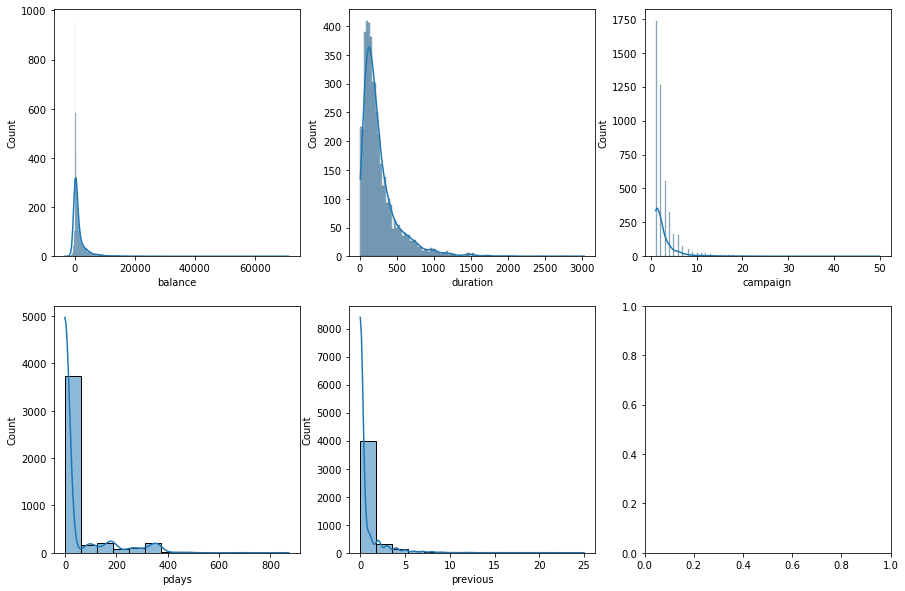

In [6]:
fig, axs = subplots(2,3, figsize=(15,10))
histplot(data = bank, x = "balance", kde = True, ax=axs[0,0])
histplot(data = bank, x = "duration", kde = True, ax=axs[0,1])
histplot(data = bank, x = "campaign", kde = True, ax=axs[0,2])
histplot(data = bank, x = "pdays", kde = True, ax=axs[1,0])
histplot(data = bank, x = "previous", kde = True, ax=axs[1,1])
savefig("skew.png")

The columns `balance`, `duration`, `campaign`, `pdays`, and `previous` are highly skewed to the right according to the table and plots. Therefore, perform log transformations on these columns.

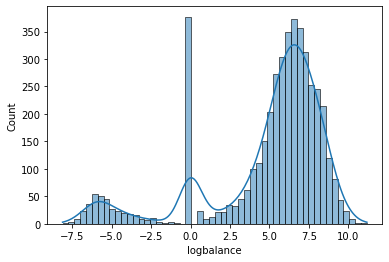

In [7]:
def reallog(x):
    if x < 0: return -log(-x)
    elif x == 0: return 0;
    else: return log(x)
bank["logbalance"] = bank['balance'].apply(reallog)
histplot(data = bank, x = "logbalance", kde = True)
savefig("log_transformation.png")

Still highly skewed, perform another square root operation on it.

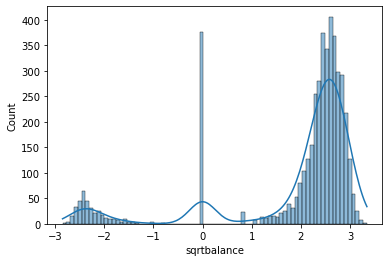

In [8]:
def realsqrt(x):
    if x < 0: return -sqrt(-x)
    else: return sqrt(x)
bank['sqrtbalance'] = bank['logbalance'].apply(realsqrt)
histplot(data = bank, x = "sqrtbalance", kde = True)
savefig("sqrt_transformation.png")

Perform similar log or square root transformations on other columns as well.

-0.5173183811595493


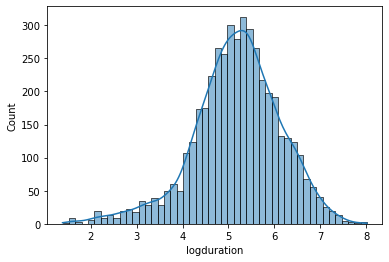

In [9]:
bank["logduration"] = bank['duration'].apply(reallog)
print(bank['logduration'].skew())
histplot(data = bank, x = "logduration", kde = True)
savefig("logduration.png")

0.8709254966680438


<AxesSubplot:xlabel='logcampaign', ylabel='Count'>

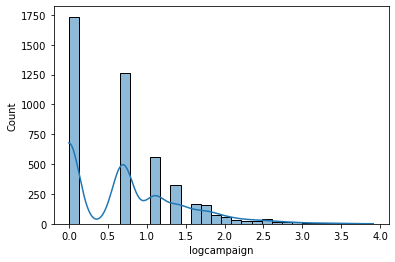

In [10]:
bank["logcampaign"] = bank['campaign'].apply(reallog)
print(bank['logcampaign'].skew())
histplot(data = bank, x = "logcampaign", kde = True)

1.731911306961672


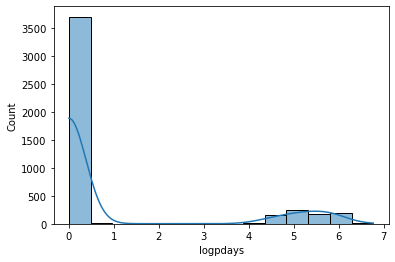

In [11]:
bank["logpdays"] = bank['pdays'].apply(reallog)
print(bank['logpdays'].skew())
histplot(data = bank, x = "logpdays", kde = True)
savefig("logpdays.png")

3.339249450238068


<AxesSubplot:xlabel='logprevious', ylabel='Count'>

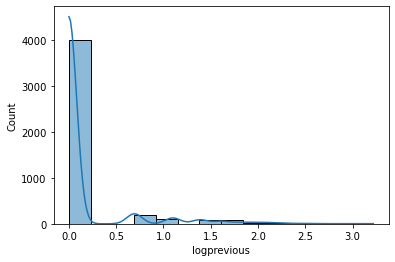

In [12]:
bank["logprevious"] = bank['previous'].apply(reallog)
print(bank['logprevious'].skew())
histplot(data = bank, x = "logprevious", kde = True)

As shown on the histograms, apart from bulk values of zero, the other values are not largely skewed.

3. One-hot encoding

As we can see from the data understanding part, a lot of the columns contain categorical value, which we have to convert to numerical values for model training. Here we apply one-hot encoding to each column.

In [13]:
bank_one_hot = get_dummies(bank, drop_first = True)

In [14]:
bank_one_hot.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'logbalance', 'sqrtbalance', 'logduration', 'logcampaign', 'logpdays',
       'logprevious', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')

In [15]:
bank_one_hot = get_dummies(bank_one_hot, columns = ["day"], drop_first = True)

In [16]:
bank_one_hot.shape

(4521, 78)

## Model Selection

After one-hot encoding, our dataset now has 78 columns. (Also some of the values are duplicate, like `duration` and `logduration`, so delete them.) Then let's test out some common models.

Perform train-test split and cross validation at first.

In [17]:
bank_final = bank_one_hot.drop(columns = ["balance", "duration", "campaign", "pdays", "previous"])
bank_final_features = bank_final.drop(columns = ["y_yes"])
bank_final_outcome = bank_final["y_yes"]
#print(bank_final_outcome)

1. Linear regression model.


Maximum Accuracy That can be obtained from this model is: 27.853228465860468 %

Minimum Accuracy: 14.020831533324852 %

Overall Accuracy: 22.22353792964766 %

Standard Deviation is: 0.044872215883882474


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


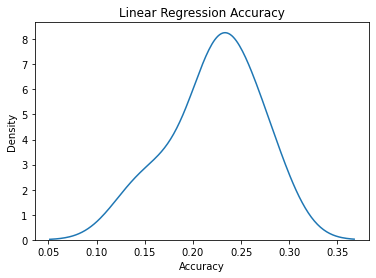

In [18]:
# Extracted and modified from https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(bank_final_features)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=99)
scores_linear = []

reglinear = linear_model.LinearRegression()

for train_index, test_index in skf.split(bank_final_features, bank_final_outcome):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = bank_final_outcome[train_index], bank_final_outcome[test_index]
    reglinear.fit(x_train_fold, y_train_fold)
    scores_linear.append(reglinear.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:', max(scores_linear)*100, '%')
print('\nMinimum Accuracy:', min(scores_linear)*100, '%')
print('\nOverall Accuracy:', mean(scores_linear)*100, '%')
print('\nStandard Deviation is:', stdev(scores_linear))
distplot(scores_linear, hist = False)
title("Linear Regression Accuracy")
xlabel("Accuracy")
savefig("linear_accuracy.png")

As shown on the distributional plot, our linear regression model works very bad on both training and test sets, achieving a accuracy of only around 25%. This is consistent with what we expected as our problem is a classification problem instead of regression.

---

2. Logistic regression model 


Maximum Accuracy That can be obtained from this model is: 91.69611307420494 %

Minimum Accuracy: 88.49557522123894 %

Overall Accuracy: 89.66997873604554 %

Standard Deviation is: 0.00982648582096296


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


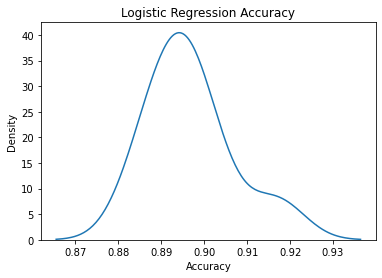

In [19]:
reglogistic = linear_model.LogisticRegression()
scores_logistic = []

bank_raw= read_csv("bank.csv", delimiter = ";")
bank_features = bank_raw.drop(columns = ["y"])
bank_target = bank_raw["y"].map(dict(yes=1, no=0))

"""for train_index, test_index in skf.split(bank_final_features, bank_final_outcome):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = bank_final_outcome[train_index], bank_final_outcome[test_index]
    reglogistic.fit(x_train_fold, y_train_fold)
    scores_logistic.append(reglogistic.score(x_test_fold, y_test_fold))"""

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(bank_final_features, bank_target)
scores_logistic = cross_val_score(reglogistic, bank_final_features, bank_target,
                                       scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')

print('\nMaximum Accuracy That can be obtained from this model is:', max(scores_logistic)*100, '%')
print('\nMinimum Accuracy:', min(scores_logistic)*100, '%')
print('\nOverall Accuracy:', mean(scores_logistic)*100, '%')
print('\nStandard Deviation is:', stdev(scores_logistic))
distplot(scores_logistic, hist = False)
title("Logistic Regression Accuracy")
xlabel("Accuracy")
savefig("logistic_accuracy")

Using Weight of Evidence Encoder


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean accuracy score: 89.737%

Using Target Encoder
Mean accuracy score: 89.825%

Using CatBoost Encoder
Mean accuracy score: 89.007%


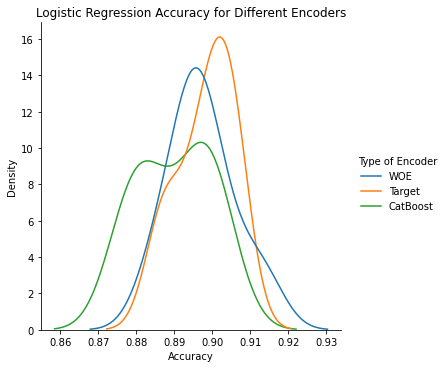

In [20]:
def logreg_test(encoder):
    acc_scores = []
    
    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(bank_features, bank_target)
    for train_id, valid_id in skf:
        enc_tr = encoder.fit_transform(bank_features.iloc[train_id,:], bank_target.iloc[train_id])
        enc_val = encoder.transform(bank_features.iloc[valid_id,:])
        regressor = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
        regressor.fit(enc_tr, bank_target.iloc[train_id])
        acc_scores.append(regressor.score(enc_val, bank_target.iloc[valid_id]))
        #probabilities = [pair[1] for pair in regressor.predict_proba(enc_val)]
        #auc_scores.append(roc_auc_score(bank_target.iloc[valid_id], probabilities))
        
    acc_scores = Series(acc_scores, name = "accuracy")
    mean_acc = acc_scores.mean() * 100
    print("Mean accuracy score: {:.3f}%".format(mean_acc))
    return acc_scores
    
##########################################
print("Using Weight of Evidence Encoder")
woe_encoder = WOEEncoder()
acc_woe = logreg_test(woe_encoder)

##########################################
print("\nUsing Target Encoder")
targ_encoder = TargetEncoder(smoothing=0.2)
acc_targ = logreg_test(targ_encoder)

##########################################
print("\nUsing CatBoost Encoder")
cb_encoder = CatBoostEncoder()
acc_cb = logreg_test(cb_encoder)

acc_woe.index = ["WOE" for i in range(acc_woe.size)]
acc_targ.index = ["Target" for i in range(acc_targ.size)]
acc_cb.index = ["CatBoost" for i in range(acc_cb.size)]
df = concat([acc_woe, acc_targ, acc_cb], axis = 0).reset_index()
df.rename({"index": "Type of Encoder"}, axis = 1, inplace = True)
displot(data = df, x = "accuracy", hue = 'Type of Encoder', kind = "kde")
title("Logistic Regression Accuracy for Different Encoders")
xlabel("Accuracy")
savefig("logistic_accuracy_encoders")

D:\Anaconda\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


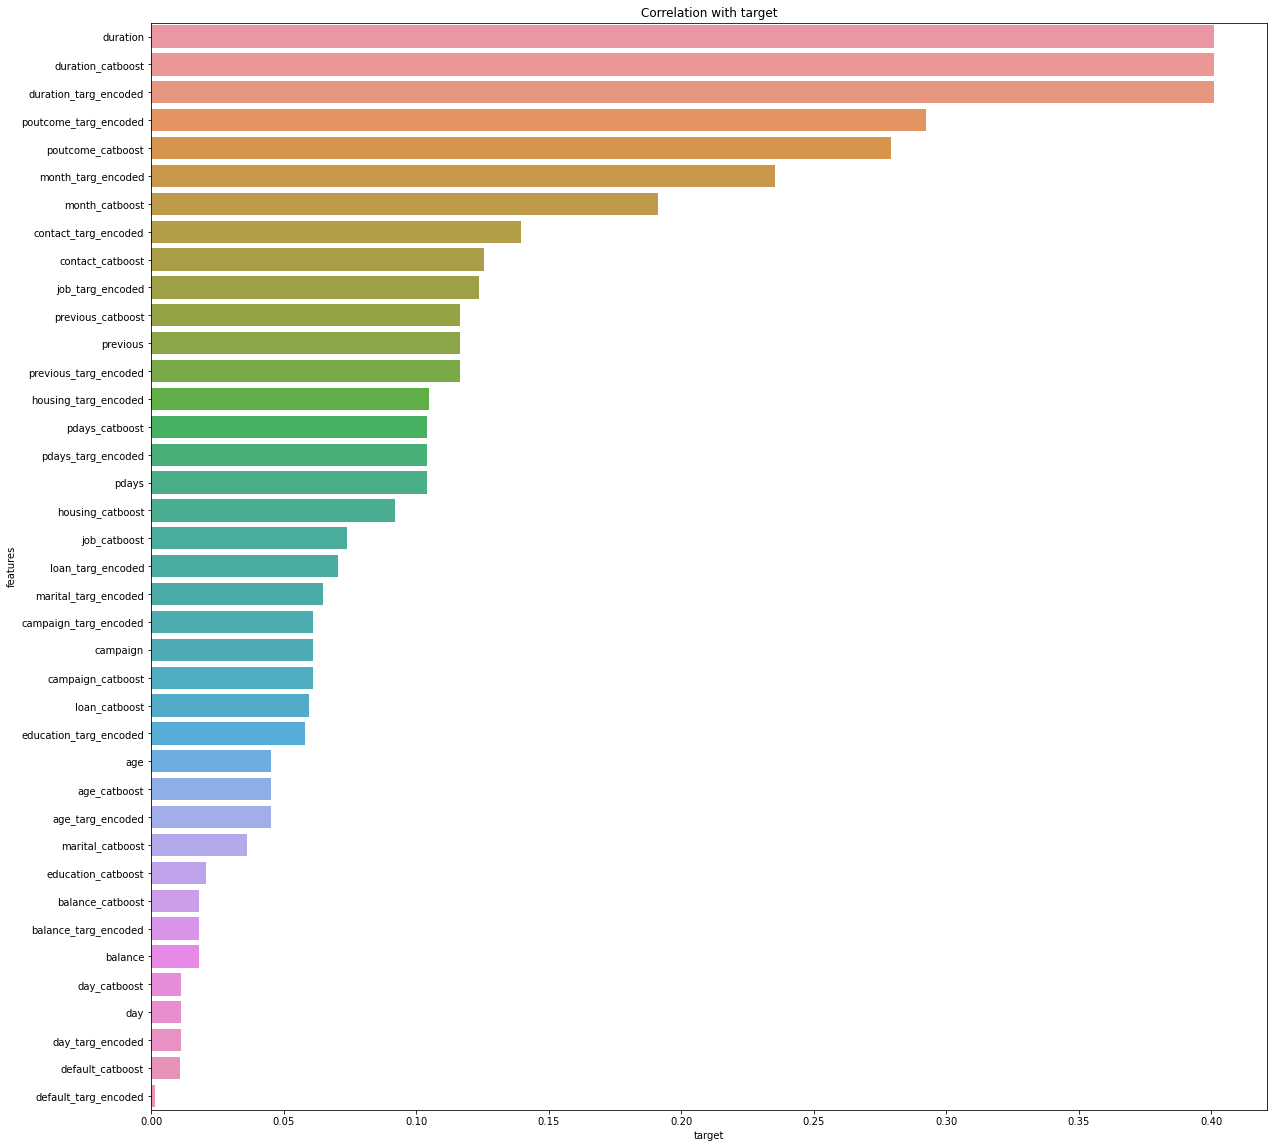

<Figure size 432x288 with 0 Axes>

In [21]:
bank_raw = read_csv("bank.csv", delimiter = ";")
bank_raw_features = bank_raw.drop(columns = ["y"])

target = TargetEncoder(smoothing=0.2)
target_train = target.fit_transform(bank_raw_features, bank_target).add_suffix('_targ_encoded')
bank_features = bank_features.join(target_train)

cb = CatBoostEncoder()
cb_train = cb.fit_transform(bank_raw_features, bank_target).add_suffix('_catboost')
bank_features = bank_features.join(cb_train)

training_set = bank_features.copy()
training_set['target'] = bank_target
corrmat = training_set.corr()
corr_with_target = corrmat['target'].apply(abs).sort_values(ascending=False)
corr_with_target.drop(['target'], inplace=True)
df = DataFrame(data={'features': corr_with_target.index, 'target': corr_with_target.values})
figure(figsize=(20, 20))
barplot(x="target", y="features", data=df)
title('Correlation with target')
#tight_layout()
show()
savefig("correlation")

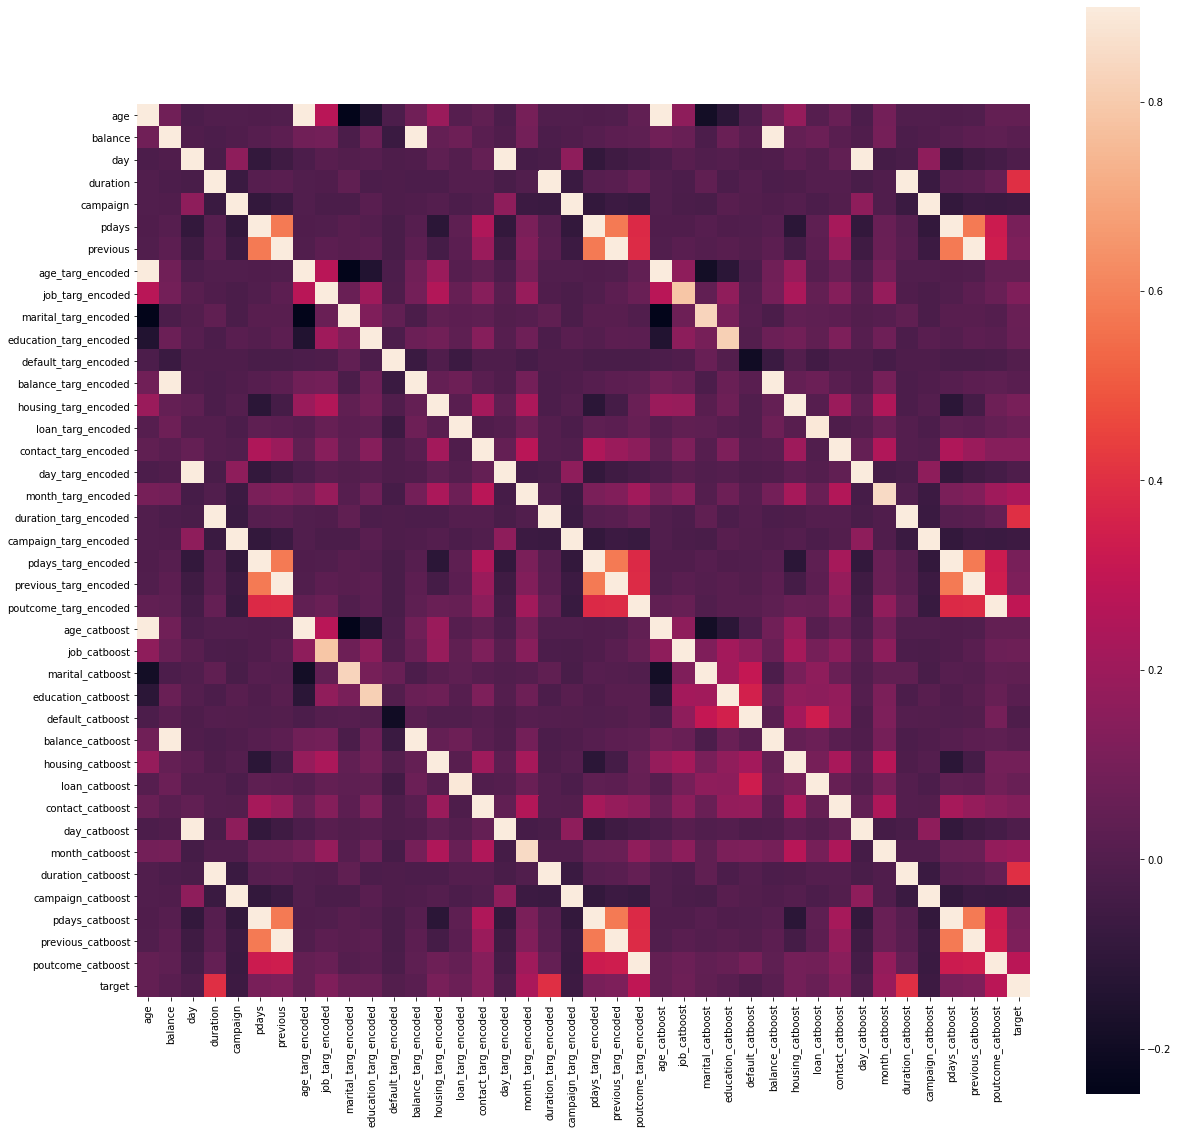

In [22]:
subplots(figsize=(20,20))
heatmap(corrmat, vmax=0.9, square=True)
savefig("correlation_heatmap")

According to the correlation plot, the three most relevant features for our models are namely `duration`, `poutcome` and surprisingly, `month`. For most numeric-valued columns, the three encoders do not increase their corrlation with `target`; but if they do, WOE encoder generally has a larger increment on correlation compared to target encoder and CatBoost. This trend is especially apparent on highly skewed colunms like `pdays` and `balance`.

3. Ensemble model - random forest
    -  One-hot encoding

Mean accuracy score: 89.405% (0.903%)


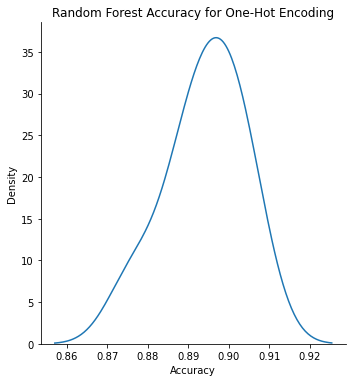

In [23]:
#X_train, X_test, y_train, y_test = train_test_split(bank_features, bank_target, test_size=0.20)
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(bank_final_features, bank_final_outcome)
random_forest_classifier = RandomForestClassifier(n_estimators = 10, random_state = 99)
random_forest_scores = cross_val_score(random_forest_classifier, bank_final_features, bank_final_outcome,
                                       scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')
displot(data = random_forest_scores, kind = "kde")
title("Random Forest Accuracy for One-Hot Encoding")
#print('Accuracy: %.3f (%.3f)' % (mean(random_forest_scores), std(random_forest_scores)))
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(random_forest_scores) * 100, std(random_forest_scores) * 100)))
xlabel("Accuracy")
savefig("random_forest_accuracy")

    - WOE, Target, and CatBoost encoding


Using WOE Encoder
Mean accuracy score: 89.383% (0.705%)


D:\Anaconda\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Using Target Encoder
Mean accuracy score: 89.737% (0.761%)

Using Catboost Encoder
Mean accuracy score: 88.940% (0.519%)


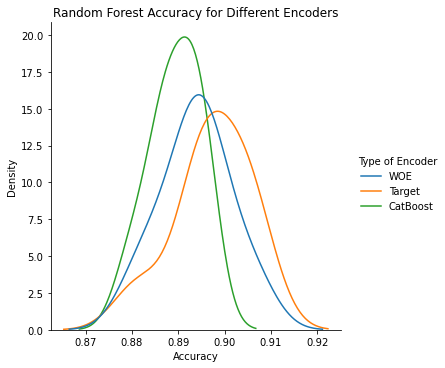

In [24]:
# Apply other three kinds of encoders.

bank_raw = read_csv("bank.csv", delimiter = ";")
bank_raw_features = bank_raw.drop(columns = ["y"])
bank_target = bank_raw["y"].map(dict(yes=1, no=0))

encoder = WOEEncoder()
woe_training_features = woe_encoder.fit_transform(bank_raw_features, bank_target).add_suffix("_woe_encoded")

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(woe_training_features, bank_target)
random_forest_scores_woe = cross_val_score(random_forest_classifier, woe_training_features, bank_target,
                                       scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')

print("\nUsing WOE Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(random_forest_scores_woe) * 100, std(random_forest_scores_woe) * 100)))

#############################################

targ_encoder = TargetEncoder(smoothing=0.2)
targ_training_features = targ_encoder.fit_transform(bank_raw_features, bank_target).add_suffix("_targ_encoded")

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(targ_training_features, bank_target)
random_forest_scores_targ = cross_val_score(random_forest_classifier, targ_training_features, bank_target,
                                       scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')
print("\nUsing Target Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(random_forest_scores_targ) * 100, std(random_forest_scores_targ) * 100)))

#####################################

cb_encoder = CatBoostEncoder()
cb_training_features = cb_encoder.fit_transform(bank_raw_features, bank_target).add_suffix("_catboost")

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state = 99).split(cb_training_features, bank_target)
random_forest_scores_cb = cross_val_score(random_forest_classifier, cb_training_features, bank_target,
                                       scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')
print("\nUsing Catboost Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(random_forest_scores_cb) * 100, std(random_forest_scores_cb) * 100)))

rf = concat([Series(random_forest_scores_woe, index = ["WOE" for i in range(random_forest_scores_woe.size)]),
            Series(random_forest_scores_targ, index = ["Target" for i in range(random_forest_scores_targ.size)]),
            Series(random_forest_scores_cb, index = ["CatBoost" for i in range(random_forest_scores_cb.size)])], axis = 0).reset_index()
rf.rename({"index": "Type of Encoder", 0: "accuracy"}, axis = 1, inplace = True)
displot(data = rf, x = "accuracy", hue = 'Type of Encoder', kind = "kde")
title("Random Forest Accuracy for Different Encoders")
xlabel("Accuracy")
savefig("random_forest_accuracy_encoders")

4. Boosting model - XGBoost

D:\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:30:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Using WOE Encoder
Mean accuracy score: 89.847% (0.723%)
[23:31:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Using Target Encoder
Mean accuracy score: 90.091% (0.624%)
[23:31:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Using CatBoost Encoder
Mean accuracy score: 89.162% (1.152%)


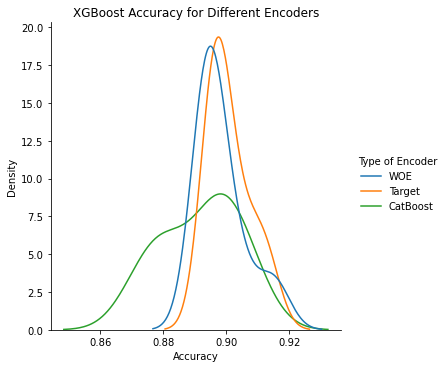

In [25]:
import xgboost
from xgboost import XGBClassifier

xgboost_woe = XGBClassifier(n_estimators = 1000, learning_rate = 0.05).fit(woe_training_features, bank_target, early_stopping_rounds = 5,
                                                                       eval_set = [(woe_training_features, bank_target)],verbose = False)
score_xgb_woe = cross_val_score(xgboost_woe, woe_training_features, bank_target, scoring='accuracy', cv=8, n_jobs=-1, error_score='raise')

print("\nUsing WOE Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(score_xgb_woe) * 100, std(score_xgb_woe) * 100)))

#############################################################

xgboost_targ = XGBClassifier(n_estimators = 1000, learning_rate = 0.05).fit(targ_training_features, bank_target, early_stopping_rounds = 5,
                                                                       eval_set = [(targ_training_features, bank_target)],verbose = False)
score_xgb_targ = cross_val_score(xgboost_targ, targ_training_features, bank_target, scoring='accuracy', cv=8, n_jobs=-1, error_score='raise')

print("\nUsing Target Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(score_xgb_targ) * 100, std(score_xgb_targ) * 100)))
#############################################################

xgboost_cb = XGBClassifier(n_estimators = 1000, learning_rate = 0.05).fit(cb_training_features, bank_target, early_stopping_rounds = 5,
                                                                       eval_set = [(cb_training_features, bank_target)],verbose = False)
score_xgb_cb = cross_val_score(xgboost_cb, cb_training_features, bank_target, scoring='accuracy', cv=8, n_jobs=-1, error_score='raise')

print("\nUsing CatBoost Encoder")
print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(score_xgb_cb) * 100, std(score_xgb_cb) * 100)))

#############################################################

xgb = concat([Series(score_xgb_woe, index = ["WOE" for i in range(score_xgb_woe.size)]),
            Series(score_xgb_targ, index = ["Target" for i in range(score_xgb_targ.size)]),
            Series(score_xgb_cb, index = ["CatBoost" for i in range(score_xgb_cb.size)])], axis = 0).reset_index()
xgb.rename({"index": "Type of Encoder", 0: "accuracy"}, axis = 1, inplace = True)
displot(data = xgb, x = "accuracy", hue = 'Type of Encoder', kind = "kde")
title("XGBoost Accuracy for Different Encoders")
xlabel("Accuracy")
savefig("xgboost_encoders")

XGBoost with target encoding achieved the highest accuracy among all models deployed, of a 90.1%. Let's try out some different learning rates and find the optimal one.

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:31:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Learning rate:  0.0001
Mean accuracy score: 89.870% (0.643%)
[23:31:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.0005
Mean accuracy score: 89.803% (0.644%)
[23:32:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.001
Mean accuracy score: 90.224% (0.650%)
[23:32:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.0025
Mean accuracy score: 90.201% (0.604%)
[23:32:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.005
Mean accuracy score: 90.069% (0.615%)
[23:32:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.01
Mean accuracy score: 90.002% (0.545%)
[23:32:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.02
Mean accuracy score: 89.670% (0.491%)
[23:33:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Learning rate:  0.04
Mean accuracy score: 89.848% (0.610%)


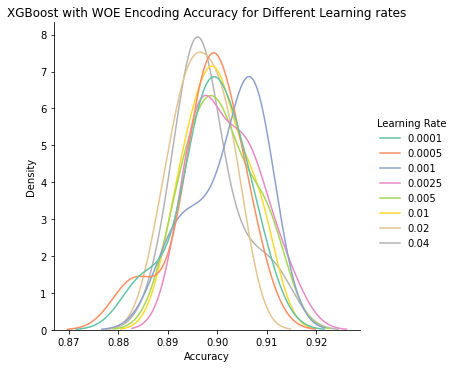

In [26]:
#%%capture --no-display
alphas = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.02, 0.04]
errseries = []
for alpha in alphas:
    xgboost_woe = XGBClassifier(n_estimators = 1000, learning_rate = alpha).fit(woe_training_features, bank_target, early_stopping_rounds = 5,
                                                                       eval_set = [(woe_training_features, bank_target)],verbose = False)
    score = cross_val_score(xgboost_woe, woe_training_features, bank_target, scoring='accuracy', cv=8, n_jobs=-1, error_score='raise')
    errseries.append(Series(score, index = [alpha for i in range(score.size)]))
    print("\nLearning rate: ", alpha)
    print(("Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(score) * 100, std(score) * 100)))
    
xgb_alpha = concat([err for err in errseries], axis = 0).reset_index()
xgb_alpha.rename({"index": "Learning Rate", 0: "accuracy"}, axis = 1, inplace = True)
#palette = ["#090364", "#091e75", "#093885", "#085396", "#086da6", "#0888b7", "#08a2c7" ]
displot(data = xgb_alpha, x = "accuracy", hue = 'Learning Rate', palette = color_palette("Set2"), kind = "kde")
title("XGBoost with WOE Encoding Accuracy for Different Learning rates")
xlabel("Accuracy")
savefig("xgboost_learningrate")

According to the studies above, the optimal learning rate is around $\alpha = 0.001$. Therefore, $\alpha = 0.001$ will be chosen for later studies.

5. Stacking Models

In [27]:
def get_stacking(metamodel, modellist):
    # define the base models
    base = list()
    for key, value in modellist.items():
        base.append((key, value))
    # define meta learner model to be logistic regression
    meta = metamodel
    # define the stacking ensemble
    model = ensemble.StackingClassifier(estimators=base, final_estimator=meta, cv=8)
    return model

In [28]:
modellist = {"Logistic Regression": linear_model.LogisticRegression(),
            "Decision Tree": DecisionTreeClassifier(),
            "SVM": SVC(), "Random forest": RandomForestClassifier(),"XGB": XGBClassifier(learning_rate = 0.001)}
for key, value in modellist.items():
    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=99).split(woe_training_features, bank_target)
    score = cross_val_score(get_stacking(value, modellist), woe_training_features, bank_target, scoring='accuracy',
                             cv=skf, n_jobs=-1, error_score='raise')
    print("\nUsing", key, ": Mean accuracy score: {:.3f}% ({:.3f}%)".format(mean(score) * 100, std(score) * 100))


Using Logistic Regression : Mean accuracy score: 89.958% (1.196%)

Using Decision Tree : Mean accuracy score: 87.127% (0.788%)

Using SVM : Mean accuracy score: 89.626% (0.629%)

Using Random forest : Mean accuracy score: 89.206% (1.077%)

Using XGB : Mean accuracy score: 88.985% (0.506%)


## Model Selection

In the above study, several ML models with different type of encoders were applied to predict customer behavior to a term deposit. Linear model failed for this study because it's a classification problem. Logstic regression, random forest, and xgboost all achieved about 90% accuracy, meaning they're all suitable for real-life predictions. To deal with the highly skewed dataset, different approaches had been taken to overcome outliers, namely logrimatic transformation, square-root transformation, weight-of-evidence (WOE) encoding, target encoding, and CatBoost. Target encoder outperforms the other two slightly for all models. Among these, **`xgboost` with target encoding** ranked 1st in terms of accuracy, at a 90.2% level. Surprisingly, stacking model did not perform as well as XGBoost, being a single component of it.

For the other part of the study, all models would be also tested on the **full** bank dataset. According to the correlation bar chart, the column `duration` contributed the most to our model. However, the phone call duration data could be hard to track in real life scenario. Therefore, `duration` column will be removed.

In [51]:
targ_training_features.columns

Index(['age_targ_encoded', 'job_targ_encoded', 'marital_targ_encoded',
       'education_targ_encoded', 'default_targ_encoded',
       'balance_targ_encoded', 'housing_targ_encoded', 'loan_targ_encoded',
       'contact_targ_encoded', 'day_targ_encoded', 'month_targ_encoded',
       'duration_targ_encoded', 'campaign_targ_encoded', 'pdays_targ_encoded',
       'previous_targ_encoded', 'poutcome_targ_encoded'],
      dtype='object')

In [49]:
import time

targ_training_features_no_duration = targ_training_features.drop(["duration_targ_encoded"], axis = 1)
start = time.time()
xgboost_final = XGBClassifier(n_estimators = 1000, learning_rate = 0.001).fit(targ_training_features_no_duration, bank_target, early_stopping_rounds = 5,
                                                                       eval_set = [(targ_training_features_no_duration, bank_target)],verbose = False)
end = time.time()
print("Elapsed time: ", end - start, "s")

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:05:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time:  2.4207959175109863 s


In [53]:
bank_full = read_csv("bank-full.csv", delimiter = ";")
full_features = bank_full.drop(["y", "duration"], axis = 1)
full_target = bank_full["y"].map(dict(yes=1, no=0))

targ_test_features = targ_encoder.fit_transform(full_features, full_target).add_suffix("_targ_encoded")
print("Prediction rate on entire dataset is {:.3f}%".format(xgboost_final.score(targ_test_features, full_target) * 100))

Prediction rate on entire dataset is 89.308%


XGBoost model with target encoding achieved 89.3% accuracy on te entire `bank_full` dataset, using only about 2 seconds to train. Therefore, this ML model is highly applicable in industry use.